# EPC LST Comparison

This notebook to explore relationship between LST or DTR and EPC data at LSOA level.

Based on LSOA_DTR_analysis


In [29]:
import os
import glob
import pprint as pp

import pandas as pd
import geopandas as gpd
import numpy as np
from numpy import ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline



In [30]:
"""Define dates of interest"""


date_label = '2013-2014'
place_label = 'derbyshire'

use_medsub_lst = True 
product_label = ('rLST' if use_medsub_lst else 'LST')


In [31]:
"""Inputs"""

# Where to find the files
rootdir = '/Users/nathan.bourne/data/thermcert/'


filename1 = rootdir+'output_LSOA_LST/{0}_{1}/lsoa_{0}_{2}_LC_EPC_daterange.geojson'.format(
    place_label,date_label,product_label)
lsoa_derb_lst = gpd.read_file(filename1) 

filename2 = rootdir+'uk_data/astrosat_data/lsoa_with_gas_and_electricity.geojson'
lsoa_consumption = gpd.read_file(filename2)

#lsoa_consumption = lsoa_consumption.to_crs(lsoa_derb_lst)

print(lsoa_derb_lst.crs)
print(lsoa_consumption.crs)


{'init': 'epsg:32630'}
{'init': 'epsg:4326'}


In [32]:
"""Merge, keeping only the geometry from the Derbyshire LSOA file"""

lsoa_derb_all = lsoa_derb_lst.merge(
                         lsoa_consumption.drop('geometry',axis=1),
                         left_on='LSOA code',
                         right_on='lsoa_code')

In [33]:
"""Define some parameters"""


for i in range(len(lsoa_derb_all)):
    assert(lsoa_derb_all['Number of'].values[i] == lsoa_derb_all['accommodation'].values[i])


Frac_on_gas_grid = (pd.to_numeric(lsoa_derb_all['gas_meters'].values
                                  ,errors='coerce') 
                    / pd.to_numeric(lsoa_derb_all['accommodation'].values
                                    ,errors='coerce') 
)
Frac_on_gas_grid[Frac_on_gas_grid>1] = 1
                                  
LST = pd.to_numeric(lsoa_derb_all['LST_mean'],errors='coerce')
GC = pd.to_numeric(lsoa_derb_all['gas_consumption'],errors='coerce') 
EC = pd.to_numeric(lsoa_derb_all['electricity_consumption'],errors='coerce') 

# These must be normalised otherwise they can't be added together
GC = GC / (np.max(GC))
EC = EC / (np.max(EC))
GCC = GC / Frac_on_gas_grid

DTR1 = (10+LST) / GC
DTR2 = (10+LST) / GCC

Frac_main_heat_gas = (pd.to_numeric(lsoa_derb_all['central_heating_gas_pct']
                                    ,errors='coerce') 
                        /100.0)
Frac_main_heat_elec = (pd.to_numeric(lsoa_derb_all['central_heating_electric_pct']
                                     ,errors='coerce') 
                        /100.0)
Frac_main_heat_other = 1.0 - Frac_main_heat_gas - Frac_main_heat_elec
                    
assert max(Frac_main_heat_other) <= 1
assert min(Frac_main_heat_other) >= 0

TC = ((GC * Frac_main_heat_gas) + (EC * Frac_main_heat_elec)) / (1 - Frac_main_heat_other)
                    
DTR3 = (10+LST) / TC



/Users/nathan.bourne/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


* DTR1 = simple:  $${\rm DTR}_1 = \frac{rLST+10}{GC}$$
* DTR2 = corrected for off-net: $${\rm DTR}_2 = \frac{rLST+10}{GC / (1 - f_{\rm off-gas})}$$
* DTR3 = combined gas + elec + other: $${\rm DTR}_3 = \frac{rLST+10}{[(GC \times f_G) + (EC \times f_E)]/(1-f_O)}$$

$rLST$ = mean of \[ LST (deg C) - median LST per scene \] over a given LSOA and date range

$f_{\rm off-gas}$ = fraction of houses off the gas network (estimated).

$f_G,f_E,f_O$ = fraction of houses with gas, electricity, or other as their main heating energy source.

In [34]:
"""Lets go with DTR3 for now"""

lsoa_derb_all = lsoa_derb_all.assign(DTR = DTR3)
lsoa_derb_all = lsoa_derb_all.assign(LST = LST)

## Do simplest comparisons against EPC data

Text(0, 0.5, 'DTR')

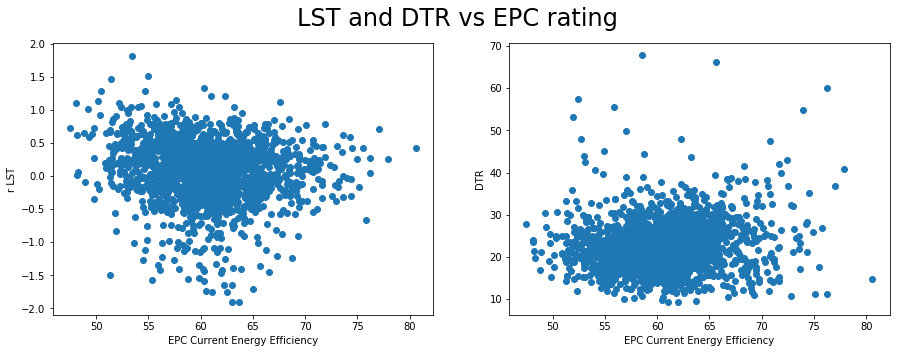

In [35]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('LST and DTR vs EPC rating',size=24)
axes[0].scatter(lsoa_derb_all['AveCEE_EPC'].values,lsoa_derb_all['LST'].values,)
axes[1].scatter(lsoa_derb_all['AveCEE_EPC'].values,lsoa_derb_all['DTR'].values,)
axes[0].set_xlabel('EPC Current Energy Efficiency')
axes[1].set_xlabel('EPC Current Energy Efficiency')
axes[0].set_ylabel('r LST')
axes[1].set_ylabel('DTR')

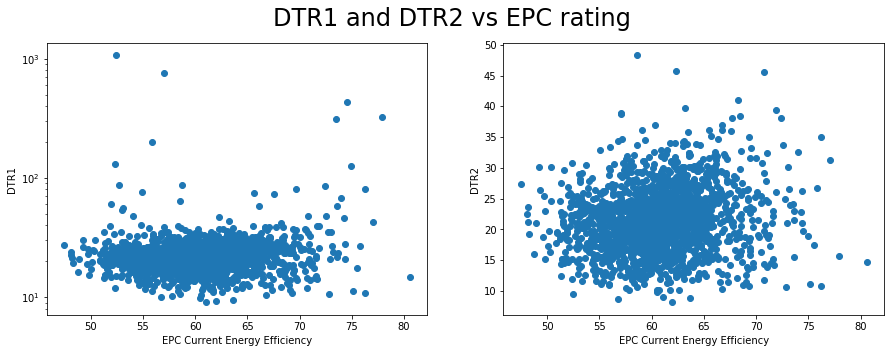

In [36]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('DTR1 and DTR2 vs EPC rating',size=24)
axes[0].scatter(lsoa_derb_all['AveCEE_EPC'].values,DTR1,)
axes[1].scatter(lsoa_derb_all['AveCEE_EPC'].values,DTR2,)
axes[0].set_xlabel('EPC Current Energy Efficiency')
axes[1].set_xlabel('EPC Current Energy Efficiency')
axes[0].set_ylabel('DTR1')
axes[1].set_ylabel('DTR2')
axes[0].set_yscale('log')

[57.74666667 68.02806499 69.03740648 ... 65.125      64.98058252
 61.67741935]
[-0.17380199 -0.20328236  0.3332073  ... -0.20136896 -0.15754322
  0.12315688]


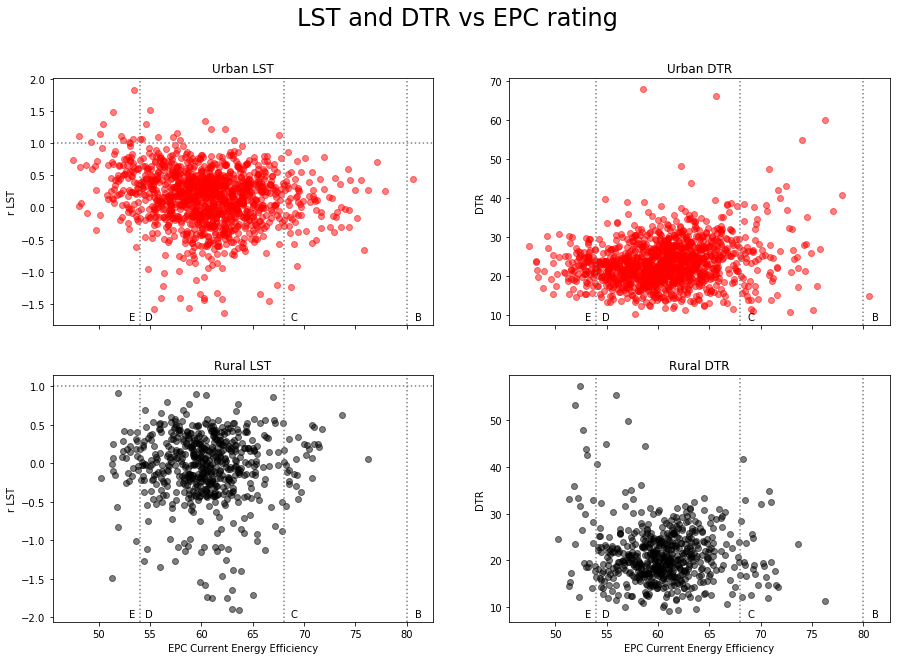

In [37]:
data1 = lsoa_derb_all['LST'].values.astype(float)
data2 = lsoa_derb_all['DTR'].values.astype(float)

ind1 = np.where((lsoa_derb_all['LC_urban'].values==1) & (data1 !=None))
ind2 = np.where((lsoa_derb_all['LC_urban'].values==0) & (data1 !=None))

print(lsoa_derb_all['AveCEE_EPC'].values[ind1])
print(data1[ind1])

fig,axes = plt.subplots(2,2,figsize=(15,10),sharex=True)
fig.suptitle('LST and DTR vs EPC rating',size=24)
axes[0,0].scatter(lsoa_derb_all['AveCEE_EPC'].values[ind1],data1[ind1],color='r',alpha=0.50)
axes[0,1].scatter(lsoa_derb_all['AveCEE_EPC'].values[ind1],data2[ind1],color='r',alpha=0.50)
axes[0,0].set_ylabel('r LST')
axes[0,1].set_ylabel('DTR')
axes[0,0].set_title('Urban LST')
axes[0,1].set_title('Urban DTR')

axes[1,0].scatter(lsoa_derb_all['AveCEE_EPC'].values[ind2],data1[ind2],color='k',alpha=0.50)
axes[1,1].scatter(lsoa_derb_all['AveCEE_EPC'].values[ind2],data2[ind2],color='k',alpha=0.50)
axes[1,0].set_ylabel('r LST')
axes[1,1].set_ylabel('DTR')
axes[1,0].set_title('Rural LST')
axes[1,1].set_title('Rural DTR')

axes[1,0].set_xlabel('EPC Current Energy Efficiency')
axes[1,1].set_xlabel('EPC Current Energy Efficiency')

"""What threshold to use for LST?"""
perc_thresh=99
LST_thresh = round(np.percentile(LST[LST>-10],perc_thresh),1)

for ax in axes:
    xran = ax[0].get_xlim()
    ax[0].plot(xran,[LST_thresh]*2,':',color='0.5')
    ax[0].set_xlim(xran)

for ax in axes.flatten():
    yran = ax.get_ylim()
    ax.plot([38]*2,yran,':',color='0.5') # EPC band F/E
    ax.plot([54]*2,yran,':',color='0.5') # EPC band E/D
    ax.plot([68]*2,yran,':',color='0.5') # EPC band D/C
    ax.plot([80]*2,yran,':',color='0.5') # EPC band C/B
#     ax.text(38*1.01,yran[0]+(yran[1]-yran[0])*0.02,'E')
    ax.text(54*0.98,yran[0]+(yran[1]-yran[0])*0.02,'E')
    ax.text(54*1.01,yran[0]+(yran[1]-yran[0])*0.02,'D')
    ax.text(68*1.01,yran[0]+(yran[1]-yran[0])*0.02,'C')
    ax.text(80*1.01,yran[0]+(yran[1]-yran[0])*0.02,'B')
    ax.set_ylim(yran)

**We already know that EPC CEE is not well correlated with the metrics**

So what about the other parameters from the EPC?
* Roof Energy Efficiency
* Roof + Windows + Walls Energy Efficiency

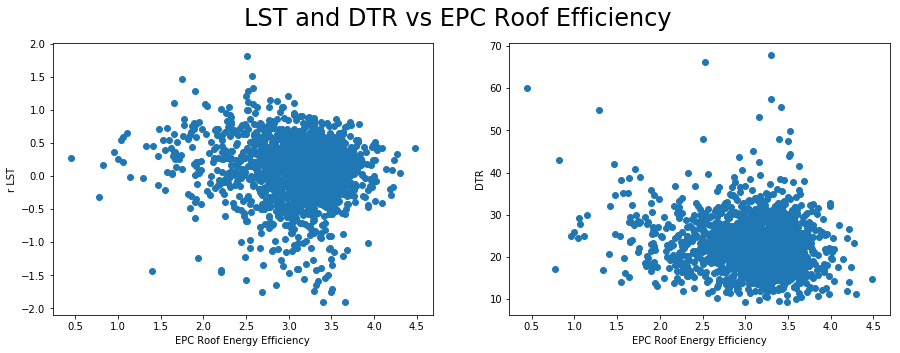

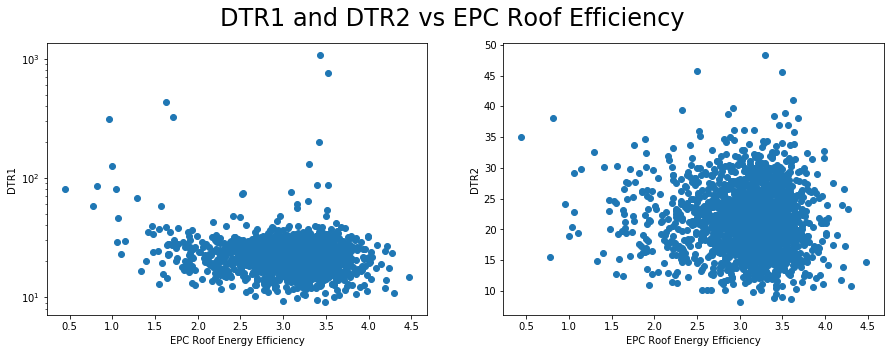

In [38]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('LST and DTR vs EPC Roof Efficiency',size=24)
axes[0].scatter(lsoa_derb_all['AveRoofEE_EPC'].values,lsoa_derb_all['LST'].values,)
axes[1].scatter(lsoa_derb_all['AveRoofEE_EPC'].values,lsoa_derb_all['DTR'].values,)
axes[0].set_xlabel('EPC Roof Energy Efficiency')
axes[1].set_xlabel('EPC Roof Energy Efficiency')
axes[0].set_ylabel('r LST')
axes[1].set_ylabel('DTR')

fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('DTR1 and DTR2 vs EPC Roof Efficiency',size=24)
axes[0].scatter(lsoa_derb_all['AveRoofEE_EPC'].values,DTR1,)
axes[1].scatter(lsoa_derb_all['AveRoofEE_EPC'].values,DTR2,)
axes[0].set_xlabel('EPC Roof Energy Efficiency')
axes[1].set_xlabel('EPC Roof Energy Efficiency')
axes[0].set_ylabel('DTR1')
axes[1].set_ylabel('DTR2')
axes[0].set_yscale('log')

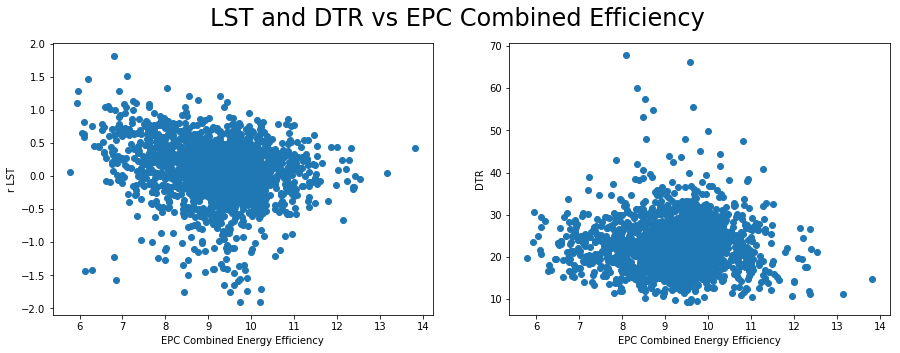

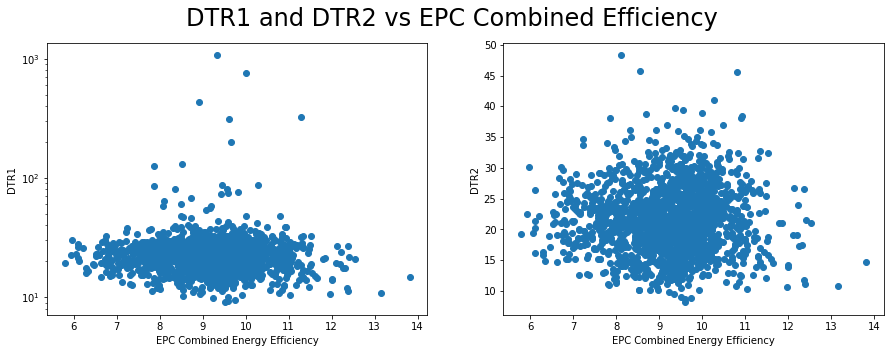

In [39]:
lsoa_derb_all = lsoa_derb_all.assign(
    AveCombEE_EPC = (lsoa_derb_all['AveRoofEE_EPC'] 
                     + lsoa_derb_all['AveWallsEE_EPC']
                     + lsoa_derb_all['AveWindowsEE_EPC'])
)

fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('LST and DTR vs EPC Combined Efficiency',size=24)
axes[0].scatter(lsoa_derb_all['AveCombEE_EPC'].values,lsoa_derb_all['LST'].values,)
axes[1].scatter(lsoa_derb_all['AveCombEE_EPC'].values,lsoa_derb_all['DTR'].values,)
axes[0].set_xlabel('EPC Combined Energy Efficiency')
axes[1].set_xlabel('EPC Combined Energy Efficiency')
axes[0].set_ylabel('r LST')
axes[1].set_ylabel('DTR')

fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('DTR1 and DTR2 vs EPC Combined Efficiency',size=24)
axes[0].scatter(lsoa_derb_all['AveCombEE_EPC'].values,DTR1,)
axes[1].scatter(lsoa_derb_all['AveCombEE_EPC'].values,DTR2,)
axes[0].set_xlabel('EPC Combined Energy Efficiency')
axes[1].set_xlabel('EPC Combined Energy Efficiency')
axes[0].set_ylabel('DTR1')
axes[1].set_ylabel('DTR2')
axes[0].set_yscale('log')

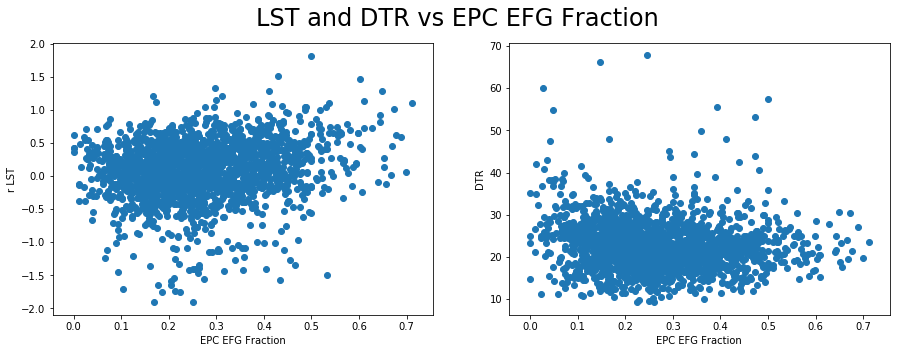

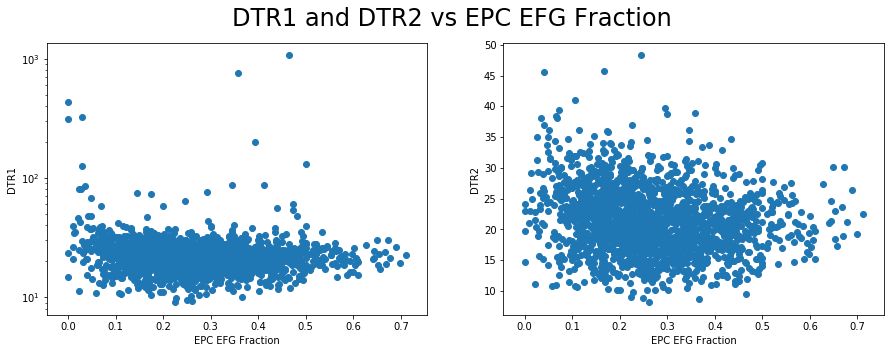

In [40]:

fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('LST and DTR vs EPC EFG Fraction',size=24)
axes[0].scatter(lsoa_derb_all['FracEFG_EPC'].values,lsoa_derb_all['LST'].values,)
axes[1].scatter(lsoa_derb_all['FracEFG_EPC'].values,lsoa_derb_all['DTR'].values,)
axes[0].set_xlabel('EPC EFG Fraction')
axes[1].set_xlabel('EPC EFG Fraction')
axes[0].set_ylabel('r LST')
axes[1].set_ylabel('DTR')

fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('DTR1 and DTR2 vs EPC EFG Fraction',size=24)
axes[0].scatter(lsoa_derb_all['FracEFG_EPC'].values,DTR1,)
axes[1].scatter(lsoa_derb_all['FracEFG_EPC'].values,DTR2,)
axes[0].set_xlabel('EPC EFG Fraction')
axes[1].set_xlabel('EPC EFG Fraction')
axes[0].set_ylabel('DTR1')
axes[1].set_ylabel('DTR2')
axes[0].set_yscale('log')

* Need to quantify these things by doing Spearman rank as well as linear regression with R^2 and slope Z-score and p-value
* What about looking at fraction of properties with an EFG rating in each LSOA?  This might help alleviate the issue where such a large number of places with average/high efficiency show no correlation between aggregate efficiency and LST
* Same for fraction with poor roofs and poor roofs+walls+windows
* Finally it would be nice to put all the plots on a big matrix with the four indicators (on the y axis) in different rows and the various EPC efficiency measures (on the x axis) in different columns 
* Similarly make a clear report on the statistical results, also being clear on whether the sense of the correlation (positive or negative) is as expected
* Having done all this, it will be worth exploring other years, and exploring the effect of narrowing or widening the date range searched.
* Having done the analysis for all, should repeat for urban and rural

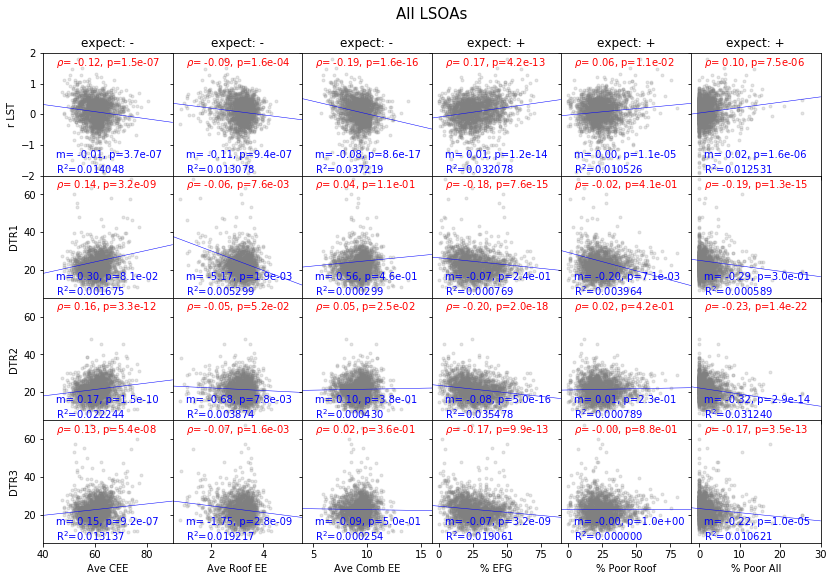

In [87]:
"""Make a big matrix of scatter plots

Rows: 
LST
DTR1
DTR2
DTR3

Cols:
EPC CEE
Roof EE
Comb EE
Frac EFG
Frac Poor Roof
Frac Poor All
"""
from scipy.stats import spearmanr, linregress

rowdata = [{'ydata':LST, 'ylabel':'r LST','ylim':[-2,2]},
           {'ydata':DTR1, 'ylabel':'DTR1','ylim':[5,70]},
           {'ydata':DTR2, 'ylabel':'DTR2','ylim':[5,70]},
           {'ydata':DTR3, 'ylabel':'DTR3','ylim':[5,70]}]

coldata = [{'xdata':lsoa_derb_all['AveCEE_EPC'].values, 'xlabel':'Ave CEE', 'xlim':[40,90], 'expect':'-'},
           {'xdata':lsoa_derb_all['AveRoofEE_EPC'].values, 'xlabel':'Ave Roof EE', 'xlim':[0.5,5.5], 'expect':'-'},
           {'xdata':lsoa_derb_all['AveCombEE_EPC'].values, 'xlabel':'Ave Comb EE', 'xlim':[4,16], 'expect':'-'},
           {'xdata':lsoa_derb_all['FracEFG_EPC'].values*100, 'xlabel':'% EFG', 'xlim':[-5,90], 'expect':'+'},
           {'xdata':lsoa_derb_all['FracPoorRoof_EPC'].values*100, 'xlabel':'% Poor Roof', 'xlim':[-5,90], 'expect':'+'},
           {'xdata':lsoa_derb_all['FracPoorAll_EPC'].values*100, 'xlabel':'% Poor All', 'xlim':[-2,30], 'expect':'+'}]

ncols=len(coldata)
nrows=len(rowdata)

fig,axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows))
fig.subplots_adjust(left=0.05,right=0.95,
                        bottom=0.05,top=0.9,
                        wspace=0.,hspace=0.) 

fig.suptitle('All LSOAs',size=15)

for jj in range(nrows):
    for ii in range(ncols):
        ax=axes[jj,ii]
        
        # Plot data
        ax.scatter(coldata[ii]['xdata'],rowdata[jj]['ydata'],marker='.',color='0.5',alpha=0.20)
        
        # Show correlation
        valid, = np.where(np.isfinite(coldata[ii]['xdata']) & np.isfinite(rowdata[jj]['ydata']))
        xdata = coldata[ii]['xdata'][valid]
        ydata = rowdata[jj]['ydata'][valid]
        
        spr,spp = spearmanr(xdata,ydata)
        ax.text(0.1,0.9,r'$\rho$= {:.2F}, p={:.1e}'.format(spr,spp),
                color='r',transform=ax.transAxes)
        
        # Show regression
        slope,intercept,r,pval,stderr = linregress(xdata,ydata)
        #print(ii,jj,slope,intercept,r**2,pval,stderr)
        xfit = np.array(coldata[ii]['xlim'])
        yfit = xfit*slope + intercept
        ax.plot(xfit,yfit,color='b',lw=0.5)
        ax.text(0.1,0.02,'m= {:.2F}, p={:.1e} \nR$^2$={:.6F}'.format(slope,pval,r**2),
                color='b',transform=ax.transAxes)
        
        # Show expectation
        if jj==0:
            ax.set_title('expect: {}'.format(coldata[ii]['expect']))
            
        # Axes 
        ax.set_xlim(coldata[ii]['xlim'])
        ax.set_ylim(rowdata[jj]['ylim'])
        
        if ii==0:
            ax.set_ylabel(rowdata[jj]['ylabel'])
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            
        if jj==nrows-1:
            ax.set_xlabel(coldata[ii]['xlabel'])
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
    

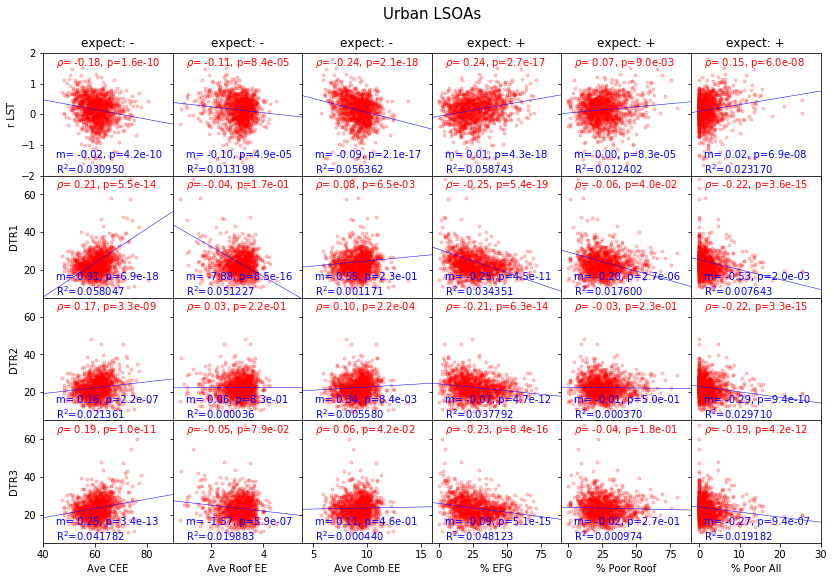

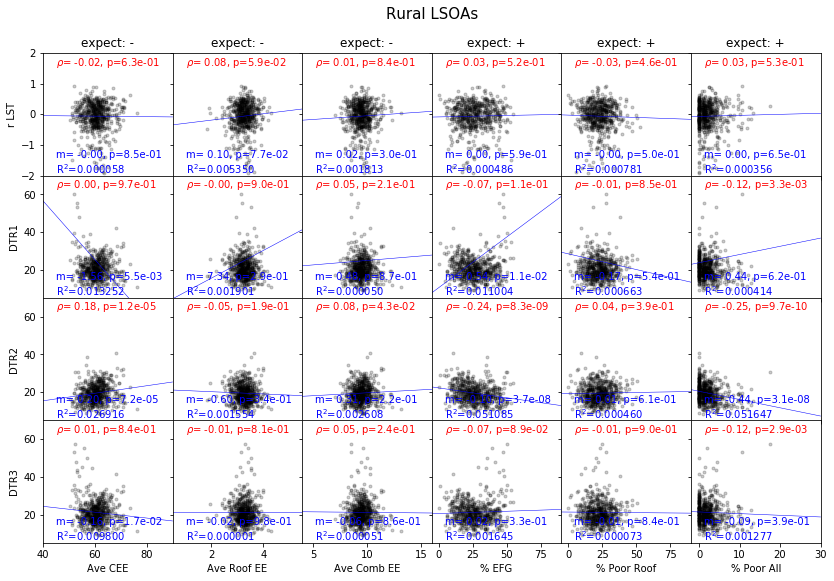

In [88]:
"""Again for urban and rural"""
from scipy.stats import spearmanr, linregress

urban = (lsoa_derb_all['LC_urban'].values==1)

fig,axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows))
fig.subplots_adjust(left=0.05,right=0.95,
                        bottom=0.05,top=0.9,
                        wspace=0.,hspace=0.) 

fig.suptitle('Urban LSOAs',size=15)

for jj in range(nrows):
    for ii in range(ncols):
        ax=axes[jj,ii]
        
        valid, = np.where(np.isfinite(coldata[ii]['xdata']) & np.isfinite(rowdata[jj]['ydata']) & urban)
        xdata = coldata[ii]['xdata'][valid]
        ydata = rowdata[jj]['ydata'][valid]
        
        # Plot data
        ax.scatter(xdata,ydata,marker='.',color='r',alpha=0.20)
        
        # Show correlation
        spr,spp = spearmanr(xdata,ydata)
        ax.text(0.1,0.9,r'$\rho$= {:.2F}, p={:.1e}'.format(spr,spp),
                color='r',transform=ax.transAxes)
        
        # Show regression
        slope,intercept,r,pval,stderr = linregress(xdata,ydata)
        #print(ii,jj,slope,intercept,r**2,pval,stderr)
        xfit = np.array(coldata[ii]['xlim'])
        yfit = xfit*slope + intercept
        ax.plot(xfit,yfit,color='b',lw=0.5)
        ax.text(0.1,0.02,'m= {:.2F}, p={:.1e} \nR$^2$={:.6F}'.format(slope,pval,r**2),
                color='b',transform=ax.transAxes)
        
        # Show expectation
        if jj==0:
            ax.set_title('expect: {}'.format(coldata[ii]['expect']))
            
        # Axes 
        ax.set_xlim(coldata[ii]['xlim'])
        ax.set_ylim(rowdata[jj]['ylim'])
        
        if ii==0:
            ax.set_ylabel(rowdata[jj]['ylabel'])
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            
        if jj==nrows-1:
            ax.set_xlabel(coldata[ii]['xlabel'])
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
        
        
fig,axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows))
fig.subplots_adjust(left=0.05,right=0.95,
                        bottom=0.05,top=0.9,
                        wspace=0.,hspace=0.) 

fig.suptitle('Rural LSOAs',size=15)

for jj in range(nrows):
    for ii in range(ncols):
        ax=axes[jj,ii]
        
        valid, = np.where(np.isfinite(coldata[ii]['xdata']) & np.isfinite(rowdata[jj]['ydata']) & ~urban)
        xdata = coldata[ii]['xdata'][valid]
        ydata = rowdata[jj]['ydata'][valid]
        
        # Plot data
        ax.scatter(xdata,ydata,marker='.',color='k',alpha=0.20)
        
        # Show correlation
        spr,spp = spearmanr(xdata,ydata)
        ax.text(0.1,0.9,r'$\rho$= {:.2F}, p={:.1e}'.format(spr,spp),
                color='r',transform=ax.transAxes)
        
        # Show regression
        slope,intercept,r,pval,stderr = linregress(xdata,ydata)
        #print(ii,jj,slope,intercept,r**2,pval,stderr)
        xfit = np.array(coldata[ii]['xlim'])
        yfit = xfit*slope + intercept
        ax.plot(xfit,yfit,color='b',lw=0.5)
        ax.text(0.1,0.02,'m= {:.2F}, p={:.1e} \nR$^2$={:.6F}'.format(slope,pval,r**2),
                color='b',transform=ax.transAxes)
        
        # Show expectation
        if jj==0:
            ax.set_title('expect: {}'.format(coldata[ii]['expect']))
            
        # Axes 
        ax.set_xlim(coldata[ii]['xlim'])
        ax.set_ylim(rowdata[jj]['ylim'])
        
        if ii==0:
            ax.set_ylabel(rowdata[jj]['ylabel'])
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            
        if jj==nrows-1:
            ax.set_xlabel(coldata[ii]['xlabel'])
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        
    

**Having done all this, it will be worth exploring other years, and exploring the effect of narrowing or widening the date range searched.**

Question:
* Can the EPCs (and maybe even the ECO) validation method be done on a postcode level rather than LSOA level, since we have such a large volume of data which may allow finer aggregation?